In [1]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import os
import torch
import timm
import torchvision.transforms as transforms
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad

import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


/cluster/home/taheeraa/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Bounding boxes and XAI within Chest X-Ray14 dataset

Want to add gradcam to alexnet baseline and compare them to the bounding boxes in the dataset.

In [3]:
root_folder = '/cluster/home/taheeraa/datasets/chestxray-14/'
images_path = f"{root_folder}images/"
file_path_bbox = root_folder + 'BBox_List_2017.csv'

num_labels = 14

labels = [
        "Atelectasis", 
        "Cardiomegaly",
        "Effusion", 
        "Infiltration", 
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",  
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia"
    ]
num_labels = len(labels) 

df_bbox = pd.read_csv(file_path_bbox)
df_bbox.head()
file_path_data_entry = root_folder + 'Data_Entry_2017.csv'
df_data_entry = pd.read_csv(file_path_data_entry)
df_data_entry.head()

merged_df = pd.merge(df_bbox, df_data_entry, on='Image Index', how='inner')
merged_df.rename(columns={
    'Bbox [x': 'x',
    'h]': 'h',
}, inplace=True)
merged_df['filepath'] = images_path + merged_df['Image Index']
merged_df.head()

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN,Atelectasis,...,13118,69,M,PA,2992,2991,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN,Atelectasis|Effusion|Mass,...,14716,53,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN,Atelectasis,...,29817,67,F,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN,Atelectasis|Cardiomegaly|Consolidation,...,14687,51,M,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN,Atelectasis,...,17877,75,F,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


## look at image index

I want to know which images has more than one bounding box related to the image

In [4]:
image_index_counts = merged_df.groupby('Image Index').size()

# Convert to DataFrame for better handling and sort
image_index_counts_df = image_index_counts.reset_index(name='Count').sort_values(by='Count', ascending=False)
image_index_counts_df

,Image Index,Count
204,00010277_000.png,4
516,00018427_004.png,3
327,00013659_019.png,3
598,00020482_032.png,3
220,00010828_039.png,3
...,...,...
309,00013209_018.png,1
310,00013249_031.png,1
312,00013249_052.png,1
313,00013272_005.png,1


Here one can see that some images has more than one bbox related to the images

In [5]:
image_index_counts_df.head(20)

,Image Index,Count
204,00010277_000.png,4
516,00018427_004.png,3
327,00013659_019.png,3
598,00020482_032.png,3
220,00010828_039.png,3
279,00012376_010.png,3
633,00021703_001.png,3
113,00005066_030.png,3
506,00018253_059.png,3
170,00008814_010.png,3


In [31]:
img_id = "00010575_002"
img_index = f"{img_id}.png"
df_filtered = merged_df[merged_df['Image Index'] == img_index]
df_filtered

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath
85,00010575_002.png,Atelectasis,232.973545,604.647619,234.057143,158.205291,NaN,NaN,NaN,Atelectasis|Effusion|Infiltration,...,10575,67,M,PA,2898,2633,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
405,00010575_002.png,Effusion,695.669841,591.644444,248.143915,174.459259,NaN,NaN,NaN,Atelectasis|Effusion|Infiltration,...,10575,67,M,PA,2898,2633,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


## loading model

In [32]:
pretrained_weights = "/cluster/home/taheeraa/code/BenchmarkTransformers/models/classification/ChestXray14/06-transformers-pre-trained/vit_base_imagenet_1k_sgd_64_bce_True/model.pth.tar"
checkpoint = torch.load(pretrained_weights, map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict']
model = timm.create_model('vit_base_patch16_224', num_classes=num_labels, pretrained=True)

msg = model.load_state_dict(state_dict, strict=False)
print('Loaded with msg: {}'.format(msg))

Loaded with msg: <All keys matched successfully>


## prepare data

In [33]:
def load_and_preprocess_images(image_path,normalize="imagenet"):
    if normalize.lower() == "imagenet":
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    elif normalize.lower() == "chestx-ray":
        normalize = transforms.Normalize([0.5056, 0.5056, 0.5056], [0.252, 0.252, 0.252])
        
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to the same size expected by the model
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Convert the image to a tensor
        normalize
    ])
    images = transform(Image.open(image_path).convert('RGB'))
    return images.unsqueeze(0)
img_path =f"/cluster/home/taheeraa/datasets/chestxray-14/images/{img_id}.png"
print(img_path)
input_tensor = load_and_preprocess_images(img_path)
print(input_tensor.size())


/cluster/home/taheeraa/datasets/chestxray-14/images/00010575_002.png
torch.Size([1, 3, 224, 224])


## model inference

In [34]:
def predict(model, batch):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        logits = model(batch)  # Forward pass
        probabilities = torch.sigmoid(logits)  # Convert logits to probabilities for multilabel classification
    return probabilities

# Perform inference
probabilities = predict(model, input_tensor)

# looking at bboxes

'/cluster/home/taheeraa/datasets/chestxray-14/images/00010575_002.png'

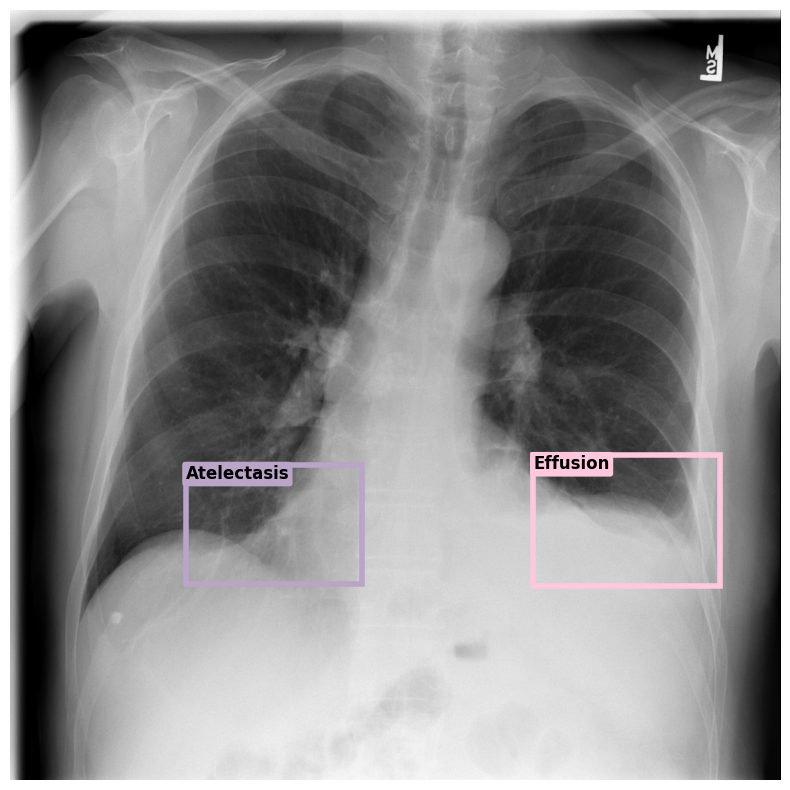

In [35]:
# Define specific colors
colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
unique_labels = df_filtered['Finding Label'].unique()
if len(unique_labels) > len(colors_list):
    print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
label_color_map = {label: colors_list[i % len(colors_list)] for i, label in enumerate(unique_labels)}

# Open the image
img = Image.open(img_path)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

# First subplot: Image with bounding boxes
ax1 = axs
ax1.imshow(img, cmap='gray')

# Draw each bounding box with its corresponding label
for idx, row in df_filtered.iterrows():
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    label = row['Finding Label']
    color = label_color_map[label]
    rect = patches.Rectangle((x, y), w, h, linewidth=4, edgecolor=color, facecolor='none')
    ax1.add_patch(rect)
    ax1.text(x, y, label, verticalalignment='top', color='black', fontsize=12, weight='bold', 
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

ax1.axis('off')
save_img_path = "/cluster/home/taheeraa/code/master-thesis/01-multi-label/notebook/xai/vit/gradcam"
plt.savefig(f"{save_img_path}/{img_id}_bbox.png")
img_path

# with vit

## gradcam

In [37]:
def predict(model, batch):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        logits = model(batch)  # Forward pass
        # Convert logits to probabilities for multilabel classification
        probabilities = torch.sigmoid(logits)
    return probabilities


# Perform inference
probabilities = predict(model, input_tensor)
predicted_labels = [labels[idx] for idx, is_predicted in enumerate(
    (probabilities > 0.2
     5).squeeze()) if is_predicted]
print(predicted_labels)
img_path

['Atelectasis', 'Effusion']


'/cluster/home/taheeraa/datasets/chestxray-14/images/00010575_002.png'

In [38]:
model.eval()
target_layers = [model.blocks[-1].norm1]


def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [39]:
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

methods = {"gradcam": GradCAM,
           "scorecam": ScoreCAM,
           "gradcam++": GradCAMPlusPlus,
           "ablationcam": AblationCAM,
           "xgradcam": XGradCAM,
           "eigencam": EigenCAM,
           "eigengradcam": EigenGradCAM,
           "layercam": LayerCAM,
           "fullgrad": FullGrad
           }

cam = methods["gradcam"](model=model,
                         target_layers=target_layers,
                         reshape_transform=reshape_transform)

In [40]:
print(img_path)
rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255

/cluster/home/taheeraa/datasets/chestxray-14/images/00010575_002.png


In [41]:
cam.batch_size = 32

grayscale_cam = cam(input_tensor=input_tensor,
                    targets=None,
                    eigen_smooth=True,
                    aug_smooth=False)

print(img_id)
grayscale_cam = grayscale_cam[0, :]

cam_image = show_cam_on_image(rgb_img, grayscale_cam)
cv2.imwrite(f'{save_img_path}/{img_id}_grad_cam_vit_in.jpg', cam_image)

00010575_002


True

## attention rollout

In [68]:
model.eval()

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Convert grayscale to RGB
rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
rgb_img.shape
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [69]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

Doing Attention Rollout
attention_rollout_id-00011925_072_dr-0.9_hf-mean
(14, 14)


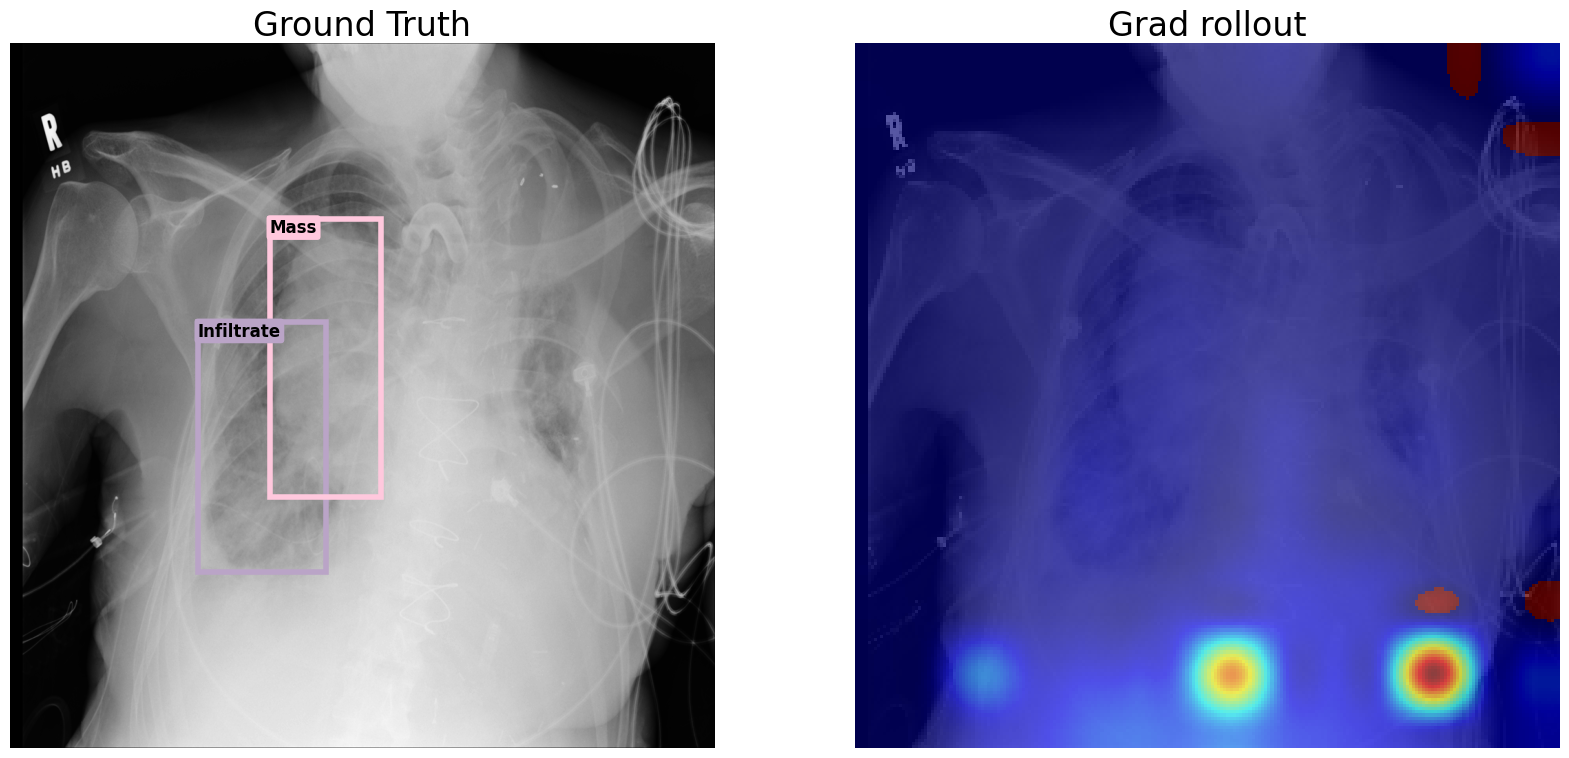

In [70]:
print("Doing Attention Rollout")
discard_ratio = 0.9
head_fusion = 'mean'
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
    discard_ratio=discard_ratio)
mask = attention_rollout(input_tensor)
name = f"attention_rollout_id-{img_id}_dr-{discard_ratio}_hf-{head_fusion}"
print(name)
print(mask.shape)

mask_resized = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_CUBIC)
mask_normalized = mask_resized / mask_resized.max()

heatmap = cv2.applyColorMap(np.uint8(255 * mask_normalized), cv2.COLORMAP_JET)

# Ensure 'rgb_img' is resized to (224, 224) if not, resize it
if rgb_img.shape[:2] != (224, 224):
    rgb_img = cv2.resize(rgb_img, (224, 224))

# Blend the heatmap with the original image
alpha = 0.6  # Transparency for the heatmap
overlayed_image = cv2.addWeighted(heatmap, alpha, rgb_img, 1 - alpha, 0)

# Convert BGR to RGB for matplotlib
overlayed_image_rgb = cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)

# Define specific colors
colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
unique_labels = df_filtered['Finding Label'].unique()
if len(unique_labels) > len(colors_list):
    print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
label_color_map = {label: colors_list[i % len(colors_list)] for i, label in enumerate(unique_labels)}

# Open the image
img = Image.open(img_path)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# First subplot: Image with bounding boxes
ax1 = axs[0]
ax1.imshow(img, cmap='gray')

# Draw each bounding box with its corresponding label
for idx, row in df_filtered.iterrows():
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    label = row['Finding Label']
    color = label_color_map[label]
    rect = patches.Rectangle((x, y), w, h, linewidth=4, edgecolor=color, facecolor='none')
    ax1.add_patch(rect)
    ax1.text(x, y, label, verticalalignment='top', color='black', fontsize=12, weight='bold', 
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

ax1.set_title("Ground Truth", fontsize=24)
ax1.axis('off')

ax2 = axs[1]
ax2.set_title("Grad rollout", fontsize=24)
ax2.imshow(overlayed_image_rgb)
ax2.axis('off')

plt.savefig(f"attention_rollout/{name}.png")

### Looking at heatmap

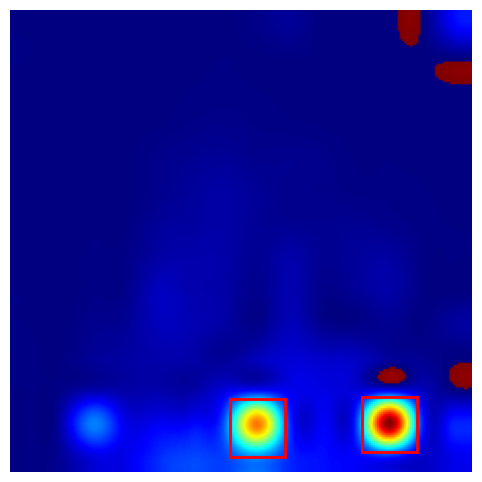

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming 'heatmap' is already computed
# Convert heatmap to grayscale for thresholding
gray_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

# Apply threshold to isolate the heated areas
_, binary_heatmap = cv2.threshold(gray_heatmap, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert BGR to RGB for matplotlib
heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Create figure and axes
fig, ax = plt.subplots(1, figsize=(10, 6))

# Display the image
ax.imshow(heatmap_rgb)

# Draw bounding boxes around each contour
for contour in contours:
    # Get the bounding rect
    x, y, w, h = cv2.boundingRect(contour)
    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

ax.set_axis_off()  # Hide axes ticks
plt.show()